In [19]:
import html
import re
import sys

import torch
from datasets import load_dataset, load_from_disk
from torch import nn

sys.path.append("../../")

from utils.helpers import create_pad_mask, create_subsequent_mask
from utils.tokenizers import BPETokenizer

In [20]:
vi_en_dataset = load_dataset(
    "mt_eng_vietnamese", "iwslt2015-vi-en", cache_dir="datasets"
)


def clean(batch):
    en = html.unescape(batch["translation"]["en"]).lower()
    vi = html.unescape(batch["translation"]["vi"]).lower()

    en = re.sub(r"\s+", " ", en).strip()
    en = " ".join(list(filter(lambda x: len(x), en.split())))
    batch["en"] = en

    vi = re.sub(r"\s+", " ", vi).strip()
    vi = " ".join(list(filter(lambda x: len(x), vi.split())))
    batch["vi"] = vi

    return batch


del vi_en_dataset["validation"]
vi_en_dataset = vi_en_dataset.map(clean, remove_columns="translation")
vi_en_dataset.save_to_disk("datasets/cleaned")

Found cached dataset mt_eng_vietnamese (/media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/mt_eng_vietnamese/iwslt2015-vi-en/1.0.0/53add551a01e9874588066f89d42925f9fad43db347199dad00f7e4b0c905a71)


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/133318 [00:00<?, ? examples/s]

Map:   0%|          | 0/1269 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/133318 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1269 [00:00<?, ? examples/s]

In [ ]:
tokenizer = BPETokenizer()
tokenizer.load_state_dict(torch.load("tokenizers/bpe.pth"))
vi_en_dataset = load_from_disk("datasets/cleaned")

In [6]:
def token2idx(batch):
    batch["ids_vi"] = (
        [tokenizer._st2i[tokenizer.sos]]
        + tokenizer(batch["vi"])
        + [tokenizer._st2i[tokenizer.eos]]
    )
    batch["ids_en"] = tokenizer(batch["en"])

    return batch


vi_en_ids = vi_en_dataset.map(
    token2idx, remove_columns=vi_en_dataset.column_names["train"]
)

In [ ]:
max_length = 256

vi_en_ids = vi_en_ids.filter(
    lambda batch: 2 < len(batch["ids_vi"]) <= max_length
    and 1 <= len(batch["ids_en"]) <= max_length
)

In [20]:
train, val = vi_en_ids["train"].train_test_split(test_size=0.01).values()
vi_en_ids.update({"train": train, "val": val})
vi_en_ids.save_to_disk("datasets/processed_ids_splits")

In [7]:
vi_en_ids = load_from_disk("datasets/processed_ids_splits")
vi_en_ids

DatasetDict({
    train: Dataset({
        features: ['ids_vi', 'ids_en'],
        num_rows: 131805
    })
    test: Dataset({
        features: ['ids_vi', 'ids_en'],
        num_rows: 1268
    })
    val: Dataset({
        features: ['ids_vi', 'ids_en'],
        num_rows: 1332
    })
})

In [8]:
print(tokenizer.decode(vi_en_ids["train"]["ids_en"][56]))

['and', ' ,', ' you', ' know', ' ,', ' built', ' the', ' society', ' that', ' we', ' now', ' live', ' in', ' .']


In [11]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

from models import Transformer
from utils.helpers import count_params

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vocab_size = len(tokenizer)
n_heads = 4
n_blocks = 2
d_model = 64
d_k = d_v = d_model // n_heads
d_ff = 4 * d_model
p_drop = 0.1

model = Transformer(
    vocab_size, n_heads, max_length, n_blocks, d_model, d_ff, d_k, d_v, p_drop
).to(device)
count_params(model)

optimizer = Adam(model.parameters(), lr=0.0002, betas=(0.98, 0.99))
scheduler = ExponentialLR(optimizer, 0.99**0.125)
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1, ignore_index=tokenizer._st2i[tokenizer.pad]
)

Total: 238,436 parameters.
Trainable: 238,436 parameters.


In [30]:
lre = torch.linspace(-6, -0.6, 1000)

In [ ]:
import math
from torch.utils.data import DataLoader
from utils.datasets import TextPairDataset, TextPairDataCollate

tp_collate = TextPairDataCollate(tokenizer)

val_dl = DataLoader(
    TextPairDataset(vi_en_ids["val"]["ids_en"], vi_en_ids["val"]["ids_vi"]),
    batch_size=32,
    pin_memory=True,
    shuffle=False,
    collate_fn=tp_collate,
)

losses = []
lrs = []
i = 0
while i < len(lre):
    for src, src_lens, tgt, tgt_lens in val_dl:
        src, src_lens, tgt, tgt_lens = (
            src.to(device),
            src_lens.to(device),
            tgt.to(device),
            tgt_lens.to(device),
        )

        src_mask = create_pad_mask(src_lens)
        tgt_0 = tgt[:, :-1]
        tgt_0_mask = create_subsequent_mask(
            tgt_lens, pad_mask=create_pad_mask(tgt_lens)
        )
        tgt_1 = tgt[:, 1:].contiguous().view(-1)

        optimizer.param_groups[0]["lr"] = math.exp(lre[i])
        logits = model(src, src_mask, tgt_0, tgt_0_mask)
        loss = loss_fn(logits.view(-1, vocab_size), tgt_1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(optimizer.param_groups[0]["lr"])

        losses.append(loss.item())
        lrs.append(lre[i])
        i += 1
        if i == len(lre):
            break

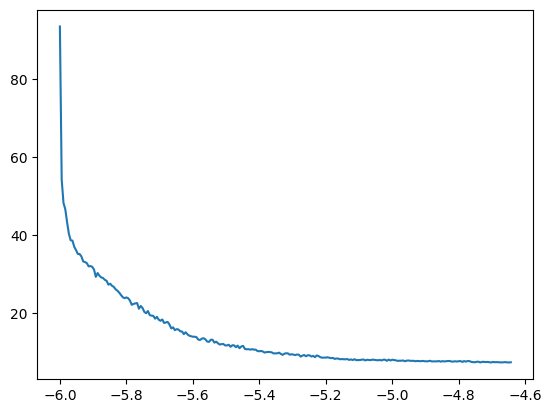

In [32]:
import matplotlib.pyplot as plt

plt.plot(lrs, losses)

In [14]:
model.load_state_dict(torch.load("checkpoints/translation-64-2-4.pth"))

<All keys matched successfully>

### Debugging

In [5]:
raw_corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]
tknr = BPETokenizer(raw_corpus, target_size=100)

Building vocabulary...: 100%|██████████| 100/100 [00:00<00:00, 14991.01it/s]


In [6]:
tknr = BPETokenizer()
tknr.load_state_dict(torch.load("tokenizers/bpe.pth"))

In [8]:
print(
    tknr.decode(
        tknr(
            [
                "<sos> Hôm nay cứ để nó thế này thôi, mai xem tiếp :D <eos> <pad>",
                "To continue, we need to apply that merge in our splits dictionary. Let’s write another function for this:",
            ]
        )
    )[0]
)

['<unk>', 'so', 's', '<unk>', ' hôm', ' nay', ' cứ', ' để', ' nó', ' thế', ' này', ' thôi', ',', ' mai', ' xem', ' tiếp', ' :', 'd', ' ', '<unk>', 'e', 'os', '<unk>', ' ', '<unk>', 'pad', '<unk>']


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_length = 20
vocab_size = 21
n_heads = 4
n_blocks = 2
d_model = 16
d_k = d_v = d_model // n_heads
d_ff = 4 * d_model
p_drop = 0.2

model = Transformer(
    vocab_size, n_heads, max_length, n_blocks, d_model, d_ff, d_k, d_v, p_drop
).to(device)
count_params(model)

optimizer = Adam(model.parameters(), lr=0.002, betas=(0.98, 0.99), weight_decay=0.01)
scheduler = ExponentialLR(optimizer, 0.999**0.125)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=0)

Total: 15,333 parameters.
Trainable: 15,333 parameters.


In [13]:
sample_data = torch.arange(1, 21).view(-1, 10).to(device)
sample_lens = torch.LongTensor([10] * 2).to(device)
sample_mask1 = create_pad_mask(sample_lens).to(device)
sample_mask2 = create_subsequent_mask(sample_lens - 1).to(device)

In [ ]:
model.train()
for i in range(5000):
    logits = model(sample_data, sample_mask1, sample_data[:, :-1], sample_mask2)
    #    print(logits.argmax(-1))
    loss = loss_fn(logits.reshape(-1, logits.size(-1)), sample_data[:, 1:].reshape(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())
    scheduler.step()

In [15]:
src_data = torch.arange(8, 18).unsqueeze(0).to(device)
src_lens = torch.LongTensor([10]).to(device)
src_mask = create_pad_mask(src_lens).to(device)

tgt_data = torch.LongTensor([[2, 3, 4]]).to(device)
tgt_lens = torch.LongTensor([3]).to(device)
tgt_mask = create_subsequent_mask(tgt_lens).to(device)

model.eval()
with torch.inference_mode():
    encoder_outputs = model.encode(src_data, src_mask)
    for i in range(12):
        logits = model.generate(tgt_data, tgt_mask, encoder_outputs, src_mask)
        # print(logits.argmax(-1))
        n = logits.softmax(-1).argmax(-1)[:, [-1]]
        tgt_data = torch.cat([tgt_data, n], dim=1).to(device)
        tgt_lens += 1
        tgt_mask = create_subsequent_mask(tgt_lens).to(device)

print(tgt_data)

tensor([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 10, 20, 20, 20, 20, 20]],
       device='cuda:0')


In [18]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from utils.helpers import bleu_score

a = [1, 3, 5, 6, 9, 7, 8, 9, 8, 10, 8]
b = [1, 3, 5, 6, 8, 10, 3, 8]

print(bleu_score([a], [b], tknr))
print(sentence_bleu([b], a, (1.0,)))

0.6363636363636364
0.6363636363636364
